# Plot the Scatter Plot and Time Series Errors

In [21]:
from pathlib import Path
import os
import warnings
from typing import Optional, List, Tuple, Dict

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/tommy/ml_drought


In [22]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm

mpl.rcParams['figure.dpi'] = 150

In [23]:
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [24]:
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

# Read in the data

In [25]:
EXPERIMENT =        'one_timestep_forecast' # '2020_04_23:190425_one_timestep_forecast' 
TRUE_EXPERIMENT =   'one_timestep_forecast'
TARGET_VAR =        'discharge_spec'
STATIC_DATA_FILE =  'data.nc' # '2020_04_23:112630_data.nc_'
DYNAMIC_DATA_FILE = 'data.nc'
N_EPOCHS = 100

# assert (data_dir / f"RUNOFF/models/{EXPERIMENT}").exists()
assert (data_dir / f"RUNOFF/features/{TRUE_EXPERIMENT}").exists()

In [26]:
# read in the training data
ds = xr.open_dataset(data_dir / f'RUNOFF/features/{TRUE_EXPERIMENT}/{DYNAMIC_DATA_FILE}')

# static_ds = xr.open_dataset(Path(f'data/features/static/data.nc'))
all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

ds['station_id'] = ds['station_id'].astype(int)

In [27]:
# 13 test stations
catchment_ids = [int(c) for c in ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]]
catchment_names = ["Dee@Park", "Tay@Ballathie", "Ouse@Skelton", "Ure@Kilgram", "Derwent@Buttercrambe", "Thames@Kingston", "Ock@Abingdon", "Avon@Knapp", "Tamar@Gunnislake", "Severn@Bewdley", "Severn@Haw", "Ribble@Samlesbury", "Clyde@Daldowie"]
station_map = dict(zip(catchment_ids, catchment_names))

# Open the Less Vars experiments (2004-2015 test)

In [28]:
print([d.name for d in (data_dir/'runs/').iterdir()])
print([d.name for d in (data_dir/'runs').glob('*_less_vars*/*E015.csv')])

['ealstm_less_vars_2004_1607_1334', 'lstm_less_vars_1307_1717', 'ealstm_less_vars_2004_1707_1424', 'lstm_less_vars_2004_1507_1028', 'train_data.h5', 'train_data_scaler.p']
['results_lstm_less_vars_1307_1717_E015.csv', 'results_ealstm_less_vars_2004_1707_1424_E015.csv', 'results_lstm_less_vars_2004_1507_1028_E015.csv']


In [29]:
lstm_df = pd.read_csv(data_dir / "runs/lstm_less_vars_2004_1507_1028/results_lstm_less_vars_2004_1507_1028_E015.csv")
lstm_df["time"] = pd.to_datetime(lstm_df["time"])

In [30]:
ealstm_df = pd.read_csv(data_dir / "runs/ealstm_less_vars_2004_1707_1424/results_ealstm_less_vars_2004_1707_1424_E015.csv")
ealstm_df["time"] = pd.to_datetime(ealstm_df["time"])

In [31]:
lstm_preds = lstm_df.set_index(["station_id", "time"]).to_xarray()
ealstm_preds = ealstm_df.set_index(["station_id", "time"]).to_xarray()

# Calculate Errors

In [32]:
from src.analysis.evaluation import spatial_rmse, spatial_r2, spatial_nse
from src.analysis.evaluation import temporal_rmse, temporal_r2, temporal_nse
from src.analysis.evaluation import _nse_func, _rmse_func, _r2_func

def error_func(preds_xr: xr.Dataset, error_str: str) -> pd.DataFrame:
    lookup = {
        "nse": _nse_func,
        "rmse": _rmse_func,
        "r2": _r2_func,
    }
    error_func = lookup[error_str]
    
    df = preds_xr.to_dataframe()
    df = df.dropna(how='any')
    df = df.reset_index().set_index("time")

    station_ids = df["station_id"].unique()
    errors = []
    for station_id in station_ids:
        d = df.loc[df["station_id"] == station_id]
        if error_str == "rmse":
            _error_calc = error_func(d["obs"].values, d["sim"].values, n_instances=d.size)
        else:
            _error_calc = error_func(d["obs"].values, d["sim"].values)
        errors.append(_error_calc)

    error = pd.DataFrame({"station_id": station_ids, error_str: errors})
    
    return error

In [33]:
errors = [ 
    error_func(ealstm_preds, "nse").set_index('station_id'),
    error_func(ealstm_preds, "r2").set_index('station_id'), 
    error_func(ealstm_preds, "rmse").set_index('station_id'),
]
ealstm_metric_df = errors[0].join(errors[1].join(errors[2])).reset_index()

errors = [ 
    error_func(lstm_preds, "nse").set_index('station_id'),
    error_func(lstm_preds, "r2").set_index('station_id'), 
    error_func(lstm_preds, "rmse").set_index('station_id'),
]
lstm_metric_df = errors[0].join(errors[1].join(errors[2])).reset_index()

# Open FUSE Models

In [42]:
all_paths = [d for d in (data_dir / "RUNOFF/FUSE/Timeseries_SimQ_Best/").glob("*_Best_Qsim.txt")]

if not (data_dir / "RUNOFF/ALL_fuse_ds.nc").exists():
    all_dfs = []
    for txt in tqdm(all_paths):
        df = pd.read_csv(txt, skiprows=3, header=0)
        df.columns = [c.rstrip().lstrip() for c in df.columns]
        df = df.rename(columns={"YYYY": "year", "MM": "month", "DD": "day"})
        df["time"] = pd.to_datetime(df[["year", "month", "day"]])
        station_id = int(str(txt).split("/")[-1].split("_")[0])
        df["station_id"] = [station_id for _ in range(len(df))]
        df = df.drop(["year", "month", "day", "HH"], axis=1).set_index(["station_id", "time"])
        all_dfs.append(df)
        
    fuse_ds = pd.concat(all_dfs).to_xarray()
    fuse_ds.to_netcdf(data_dir / "RUNOFF/fuse_ds.nc")
    
else:
    fuse_ds = xr.open_dataset(data_dir / "RUNOFF/ALL_fuse_ds.nc")

### NOTE: only test performance on 2004-2008

In [47]:
fuse_ds = fuse_ds.sel(time=slice('2004-01-01', '2009-01-01'))

# join with observations for stations that exist
obs = (
    ds.sel(station_id=np.isin(ds["station_id"], fuse_ds["station_id"]), time=fuse_ds["time"])["target_var_original"]
).rename("discharge_spec")
fuse_data = fuse_ds.sel(station_id=obs.station_id).merge(obs)
fuse_data = fuse_data.rename({'discharge_spec': 'obs'})

### Calculate FUSE Errors

In [60]:
fuse_errors = pickle.load((data_dir / 'RUNOFF/FUSE_errors.pkl').open("rb"))

In [58]:
def get_error_df(model: str, fuse_errors: pd.DataFrame) -> pd.DataFrame:
    all_models = ["TOPMODEL", "VIC", "PRMS", "Sacramento"]
    assert model in all_models
    remove_models = [m for m in all_models if m != model]
    error_df = fuse_errors.drop(remove_models, axis=1, level=1).swaplevel(axis=1).sort_index(axis=1).droplevel(axis=1, level=0)
    rename_cols = pd.io.parsers.ParserBase({'names': error_df.columns})._maybe_dedup_names(error_df.columns)
    error_df.columns = [n if n != "nse" else "Name" for n in rename_cols]
    return error_df.rename({"nse.1": "nse"}, axis=1)


topmodel = fuse_data[["obs", "SimQ_TOPMODEL"]].to_dataframe().reset_index()
vic = fuse_data[["obs", "SimQ_ARNOVIC"]].to_dataframe().reset_index()
prms = fuse_data[["obs", "SimQ_PRMS"]].to_dataframe().reset_index()
sacramento = fuse_data[["obs", "SimQ_SACRAMENTO"]].to_dataframe().reset_index()

top_error = get_error_df("TOPMODEL", fuse_errors)
vic_error = get_error_df("VIC", fuse_errors)
prms_error = get_error_df("PRMS", fuse_errors)
sac_error = get_error_df("Sacramento", fuse_errors)

# Create Plotting Algos

In [34]:
def plot_station_scatter(
    df: pd.DataFrame, 
    station_id: str, 
    metrics_df: Optional[pd.DataFrame] = None, 
    ax=None,
    target_var: str = 'discharge_spec',
    station_name: Optional[str] = None,
    color_by_season: bool = None,
):
    # select station
    d = df.query(f"station_id == '{station_id}'").drop(columns='station_id')
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    else:
        fig = plt.gcf()
    
    if not color_by_season:
        # plot scatter
        ax.plot(d[target_var], d.preds, 'kx', alpha=0.6, label='Data Point')
    else:
        seasons = ds.sel(time=d.index)["time.season"].values
        d["season"] = seasons
        for ix, season in enumerate(d.season.unique()):
            ax.scatter(
                d.loc[d["season"] == season, target_var], 
                d.loc[d["season"] == season, "preds"], 
                color=sns.color_palette()[ix], 
                alpha=0.6, 
                label=season,
                marker="x"
            )
            sns.regplot(
                d.loc[d["season"] == season, target_var], 
                d.loc[d["season"] == season, "preds"], 
                color=sns.color_palette()[ix],
                ax=ax,
                scatter=False,
                ci=None,
            )
    # plot 1:1 line
    line_1_1_x = np.linspace(d[target_var].min(), d[target_var].max(), 10)
    ax.plot(line_1_1_x, line_1_1_x, 'k--', label='1:1 Line')

    ax.set_xlabel('Observed $[mm d^{-1} km^{-2}]$')
    ax.set_ylabel('Predicted $[mm d^{-1} km^{-2}]$')
    title = f'Station {station_id}' + f" {station_name}" if station_name is not None else f'Station {station_id}'
    ax.set_title(title)

    ax.legend();
    
    if False:
        # making the plot pretty
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                          + ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(12)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    return fig, ax


def plot_station(
    df: pd.DataFrame, 
    station_id: str, 
    metrics_df: Optional[pd.DataFrame] = None, 
    ax=None,
    station_name: Optional[str] = None,
    plot_years: Optional[List[int]] = None,
):
    """Plot the Observed vs. Preds for the station_id"""
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()
    
    # plot the station
    if plot_years is None:
        df.query(f"station_id == '{station_id}'").drop(columns='station_id').plot(ax=ax)
    else:
        (
            df.loc[np.isin(df.index.year, plot_years)]
            .query(f"station_id == '{station_id}'")
            .drop(columns='station_id').plot(ax=ax)
        )
    
    # get the error metrics
    rmse_val = metrics_df.query(f"station_id == '{station_id}'").rmse.values[0]
    r2_val = metrics_df.query(f"station_id == '{station_id}'").r2.values[0]
    nse_val = metrics_df.query(f"station_id == '{station_id}'").nse.values[0]
    # set the title
    station_title = f"{station_id} {station_name}" if station_name is not None else station_id
    ax.set_title(f"{station_title}\nRMSE: {rmse_val:.2f} R2: {r2_val:.2f} NSE: {nse_val:.2f}")
    
    return fig, ax

In [35]:
def plot_catchment_time_series(
    df: pd.DataFrame,
    metrics_df: pd.DataFrame,
    catchment_ids: List[str],
    catchment_names: List[str],
    plot_years: List[int] = [2011],
    scale: float = 0.8,
    color_by_season: bool = False,
):
    n_plots = len(catchment_ids)
    station_map = dict(zip(catchment_ids, catchment_names))
    fig, axs = plt.subplots(n_plots, 2, figsize=(12*scale, 6*scale*n_plots))

    for ix, (station_id, station_name) in enumerate(zip(catchment_ids, catchment_names)):
    #     fig, axs = plt.subplots(1, 2, figsize=(12*scale, 6*scale))
        try:
            plot_station(df, station_id, metrics_df, ax=axs[ix, 0], station_name=station_name, plot_years=plot_years)
            plot_station_scatter(df, station_id, metrics_df, axs[ix, 1], color_by_season=color_by_season)
        except IndexError:
            # the axes are one dimensional
            plot_station(df, station_id, metrics_df, ax=axs[0], station_name=station_name, plot_years=plot_years)
            plot_station_scatter(df, station_id, metrics_df, axs[1], color_by_season=color_by_season)
        except TypeError:
            print(f"** {station_name} data does not exist in the predictions! **")

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    return fig, axs

# Get the median basins etc.

In [36]:
assert (data_dir / "RUNOFF/all_nse.csv").exists()
assert (data_dir / "RUNOFF/all_bias.csv").exists()

all_nse = pd.read_csv((data_dir / "RUNOFF/all_nse.csv"))
all_bias = pd.read_csv((data_dir / "RUNOFF/all_bias.csv"))

all_nse.head()

,Station ID,Name,TOPMODEL,VIC,PRMS,Sacramento,EALSTM,LSTM,CLASSIC,JULES
0,12002,Dee at Park,0.556630,0.633095,0.645595,0.648255,0.858937,0.865083,0.55,0.51
1,15006,Tay at Ballathie,0.803730,0.892683,0.863550,0.879369,0.924273,0.940792,0.46,0.64
2,27009,Ouse at Skelton,0.861834,0.889123,0.878628,0.900831,0.883401,0.905292,0.80,0.69
3,27034,Ure at Kilgram Bridge,0.838496,0.845481,0.846080,0.850750,0.872704,0.854971,0.78,0.75
4,27041,Derwent at Buttercrambe,0.745959,0.713918,0.781723,0.809577,0.747545,0.838306,0.65,0.49


In [37]:
median = all_nse.loc[all_nse['LSTM'] == all_nse['LSTM'].median()]
min_ = all_nse.loc[all_nse['LSTM'] == all_nse['LSTM'].min()]
max_ = all_nse.loc[all_nse['LSTM'] == all_nse['LSTM'].max()]

median_station = (median["Station ID"].values, median.Name.values)
min_station = (min_["Station ID"].values, min_.Name.values)
max_station = (max_["Station ID"].values, max_.Name.values)

pd.concat([median, min_, max_])

,Station ID,Name,TOPMODEL,VIC,PRMS,Sacramento,EALSTM,LSTM,CLASSIC,JULES
5,39001,Thames at Kingston,0.731836,0.734690,0.634762,0.818929,0.744352,0.866479,0.81,0.82
6,39081,Ock at Abingdon,0.710893,0.812519,0.708910,0.823289,0.428313,0.672750,0.80,-0.21
12,84013,Clyde at Daldowie,0.898075,0.891100,0.870042,0.905927,0.948111,0.946680,0.80,0.82


In [38]:
summary_stations = np.vstack([median_station, min_station, max_station]).reshape(3, 2)

# LSTM Errors

In [39]:
PLOT_ALL = False

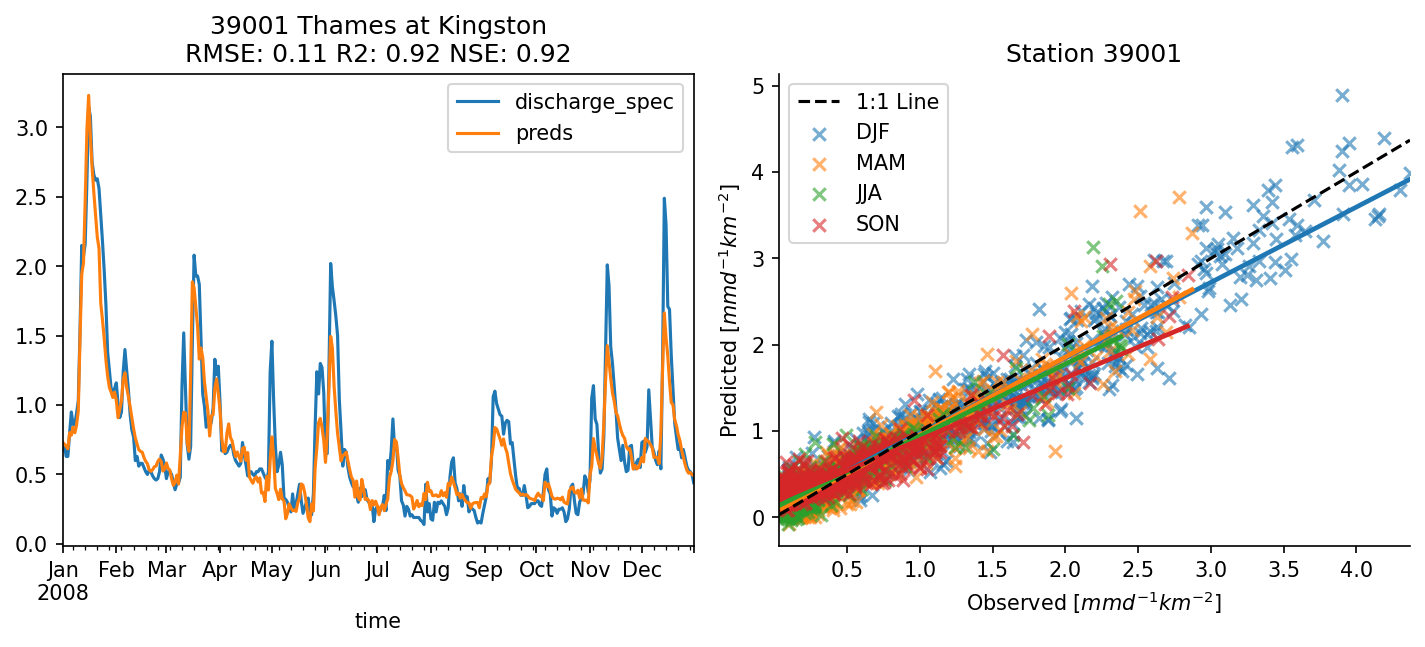

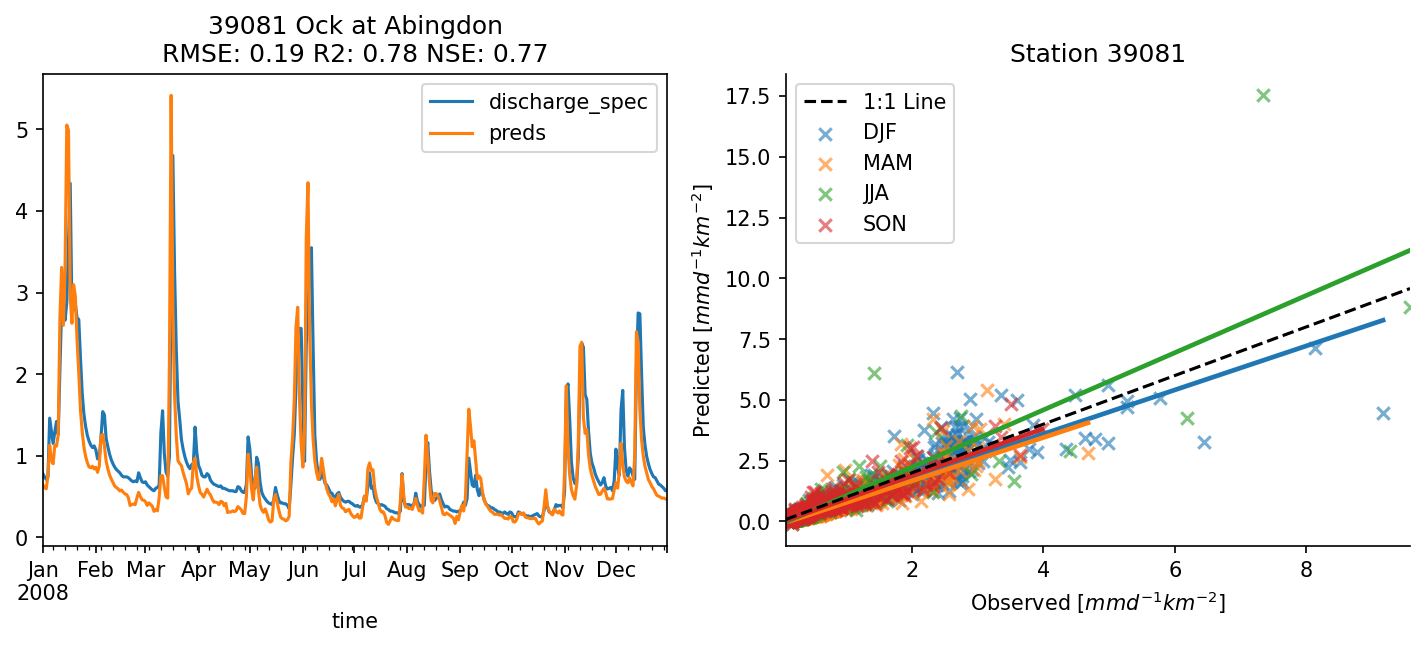

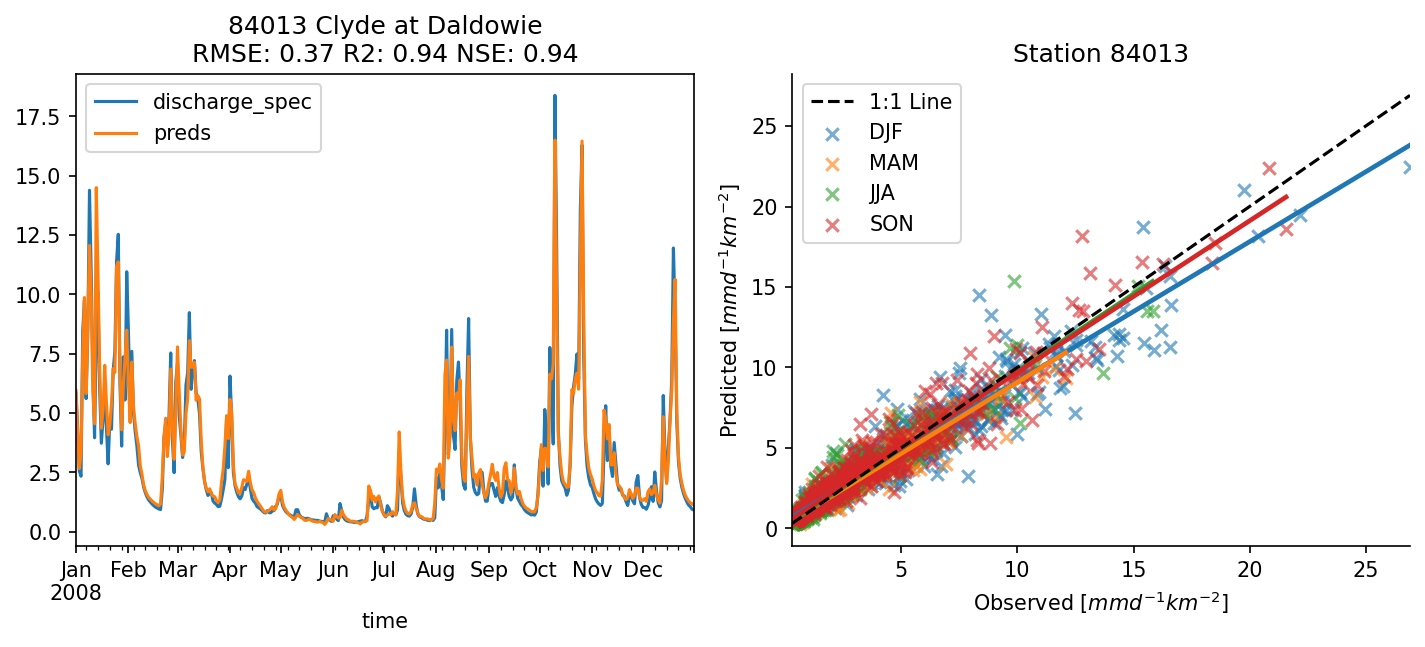

In [40]:
if PLOT_ALL:
    fig, axs = plot_catchment_time_series(
        df=lstm_less_vars.set_index("time").rename({"obs": "discharge_spec", "sim": "preds"}, axis=1),
        metrics_df=lstm_df,
        catchment_ids=catchment_ids,
        catchment_names=catchment_names,
        plot_years=[2008],
        color_by_season=True,
    );
    
else:
    for idx, name in summary_stations:
        fig, axs = plot_catchment_time_series(
            df=lstm_df.set_index("time").rename({"obs": "discharge_spec", "sim": "preds"}, axis=1),
            metrics_df=lstm_metric_df,
            catchment_ids=[idx],
            catchment_names=[name],
            plot_years=[2008],
            color_by_season=True,
        );
    

# EALSTM Errors

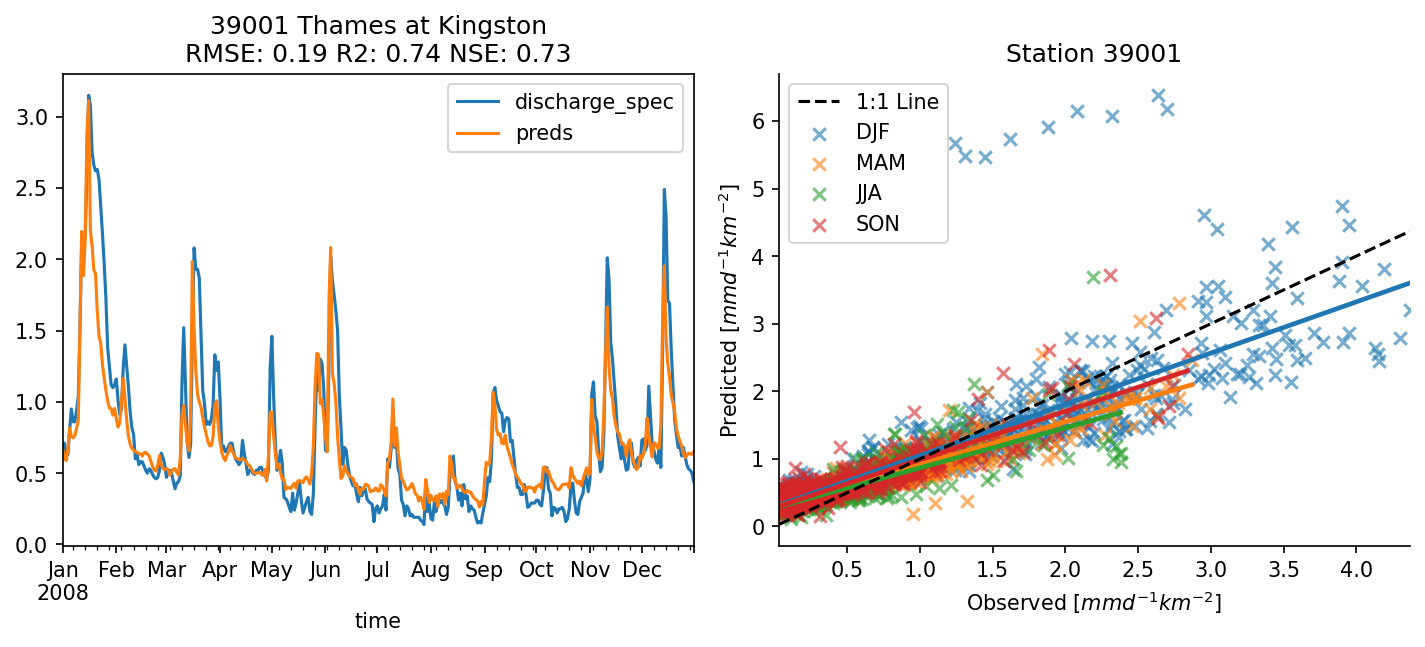

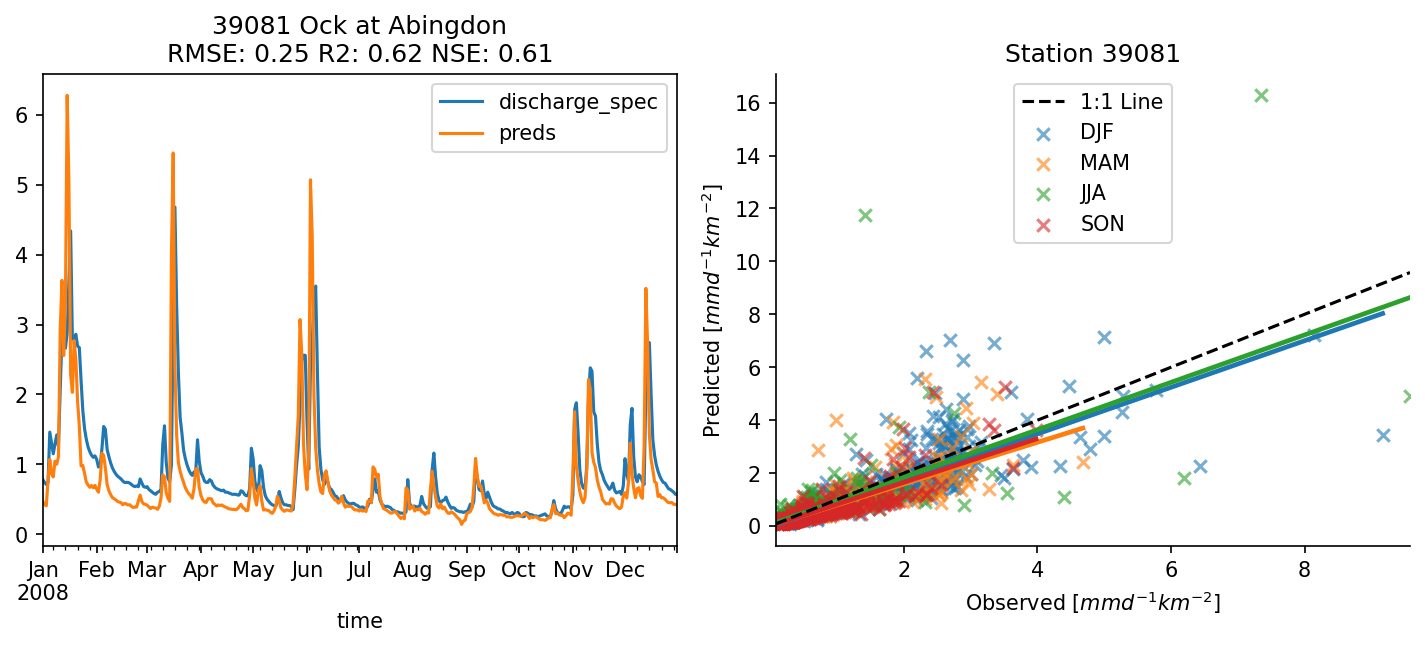

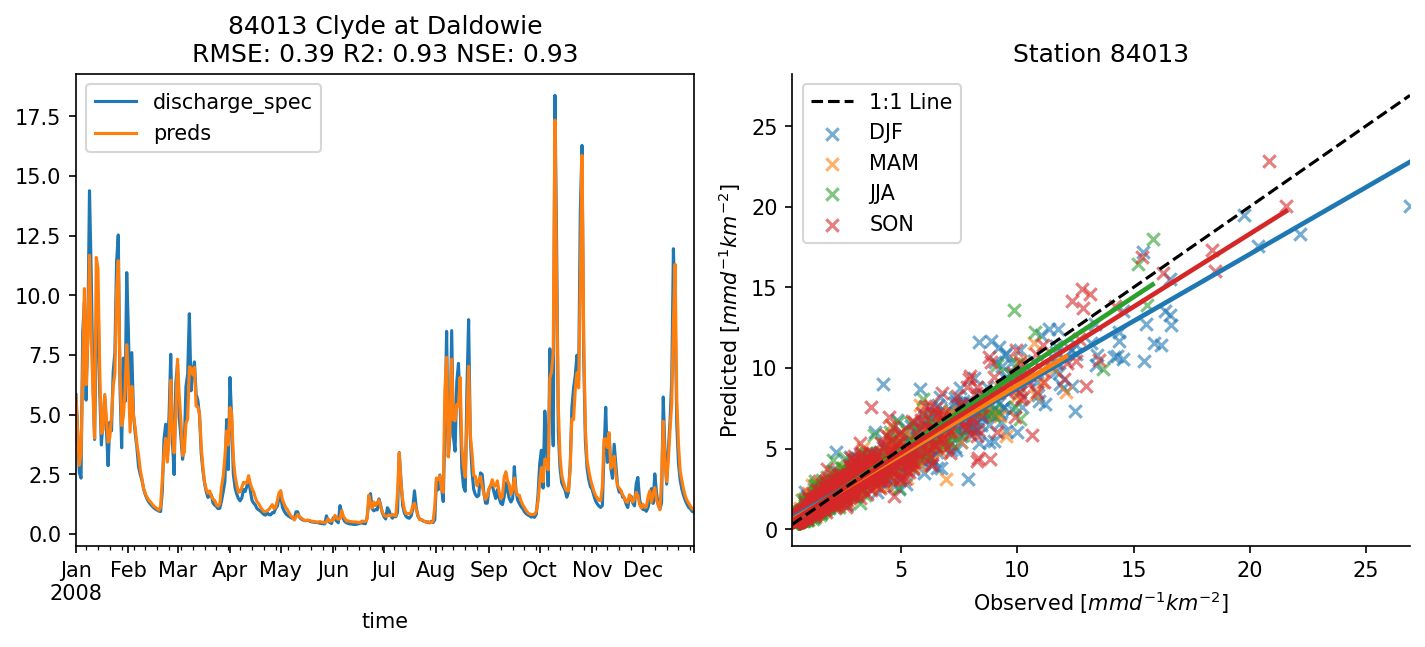

In [41]:
if PLOT_ALL:
    fig, axs = plot_catchment_time_series(
        df=ealstm_df.set_index("time").rename({"obs": "discharge_spec", "sim": "preds"}, axis=1),
        metrics_df=ealstm_metric_df,
        catchment_ids=catchment_ids,
        catchment_names=catchment_names,
        plot_years=[2008],
        color_by_season=True,
    );
    
else:
    for idx, name in summary_stations:
        fig, axs = plot_catchment_time_series(
            df=ealstm_df.set_index("time").rename({"obs": "discharge_spec", "sim": "preds"}, axis=1),
            metrics_df=ealstm_metric_df,
            catchment_ids=[idx],
            catchment_names=[name],
            plot_years=[2008],
            color_by_season=True,
        );
    

# PRMS

# TOPMODEL

# VIC

# SACRAMENTO